In [131]:
# Import required libraries
# !pip install pandas
# !pip install scikit-learn
# !pip install nltk
# !pip install matplotlib
# !pip install emoji
# !pip install langdetect
# !pip install seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import emoji
from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if needed
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

import matplotlib.pyplot as plt


## Functions

In [132]:
def preprocess_text(text):

     # TO LOWER CASE
    text = text.lower()

    # REMOVE EMOJIS
    # From https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/49146722#49146722
    def remove_emoji(string):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
        # return emoji.replace_emoji(string, replace='')

    # REMOVE URLs
    def remove_URLs(text):
        first = re.sub(r"http\S+", "", text)
        return re.sub(r"\\\/\S+", "", first)

    # REMOVE USERNAME MENTIONS
    def remove_Mentions(text):
        return re.sub(r"@\w+","", text)

    # REMOVE STOP WORDS
    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_text = ' '.join(filtered_words)
        return filtered_text


    # REMOVE SPECIAL CHARACTERS
    def clean_text(text):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    def stem_words(text):
        porter = PorterStemmer()
        words = word_tokenize(text)
        stemmed_words = [porter.stem(word) for word in words]

        return ' '.join(stemmed_words)
    
    def lemmatize_words(text):
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(lemmatized_words)

    
    text = remove_emoji(text)
    text = remove_URLs(text)
    text = remove_Mentions(text)
    text = remove_stopwords(text)
    text = clean_text(text)
    # text = stem_words(text)
    # text = lemmatize_words(text)
    return text

In [133]:
def stem_words(text):
    porter = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [porter.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [134]:
def lemmatize_words(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_words)

In [135]:
def getMetrics(y_true, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=['fake','real'])
    TP, FP, FN, TN = conf_matrix.ravel()
    print("Confusion Matrix:")
    print(conf_matrix)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    print("TP: %d FP: %d TN: %d FN: %d" % (TP, FP, TN, FN))
    print("Precision: %0.3f" % precision)
    print("Recall: %0.3f" % recall)
    print("F1 Score: %0.3f" % f1)

    # Plot confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['fake','real'], yticklabels=['fake','real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix\nPrecision: %0.3f, Recall: %0.3f, F1 Score: %0.3f' % (precision, recall, f1))
    
    plt.savefig('imgs/confMatrix.png', bbox_inches='tight')
    plt.show()

## Loading the Data

In [136]:
# Load training and test data
train_df = pd.read_csv("dataset/mediaeval-2015-trainingset.txt", sep="\t")
test_df = pd.read_csv("dataset/mediaeval-2015-testset.txt", sep="\t")

train_df.info()

# Replace 'humor' label with 'fake' -------------------------------------------------------------------
train_df['label'] = train_df['label'].replace('humor', 'fake')
test_df['label'] = test_df['label'].replace('humor', 'fake')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


## Data Analysis

### Count number of real/fake/humor labels

In [137]:
# # Count real/fake/homor labels
# label_counts = train_df['label'].value_counts()
# fake_humor_sum = label_counts.get('fake', 0) + label_counts.get('humor', 0)
# label_counts['fake+humor'] = fake_humor_sum
# ordered_labels = ['real', 'fake+humor', 'fake', 'humor']
# label_counts = label_counts.reindex(ordered_labels)

# plt.figure(figsize=(6, 4))
# label_counts.plot(kind='bar', color=['green', 'blue', 'red', 'orange'])

# plt.title("Number of real/fake/humor Labels")
# plt.xlabel("Tweet Category")
# plt.ylabel("Frequency")

# # Add text labels on top of each bar
# for i, val in enumerate(label_counts):
#     plt.text(i, val + 10, str(val), ha='center', va='bottom')

# plt.savefig('imgs/labelFreq.png', bbox_inches='tight') 

# plt.show()

# print(train_df['label'].value_counts())

### Tweet lengths

In [138]:
# # Calculate text length and plot text length distribution

# text_lengths = train_df['tweetText'].apply(len)

# plt.figure(figsize=(6, 4))
# plt.hist(text_lengths, bins=range(0,170,10), color='skyblue')
# plt.title('Text Length Distribution')
# plt.xlabel('Text Length')
# plt.ylabel('Frequency')
# plt.grid(True)

# plt.savefig('imgs/textLengthDist.png', bbox_inches='tight') 

# plt.show()

# # Plotting text length distribution for 'real' and 'fake/humor' tweets
# plt.figure(figsize=(6, 4))

# plt.hist(train_df[train_df['label'].isin(['fake', 'humor'])]['tweetText'].apply(len), bins=range(0,170,10), color='blue', alpha=0.7, label='Fake/Humor')
# plt.hist(train_df[train_df['label'] == 'real']['tweetText'].apply(len), bins=range(0,170,10), color='green', alpha=0.7, label='Real')

# plt.title('Text Length Distribution for Real and Fake/Humor Tweets')
# plt.xlabel('Text Length')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# plt.savefig('imgs/textLengthDistRvF.png', bbox_inches='tight')  # bbox_inches='tight' ensures the entire plot is saved without cropping

# plt.show()

# # Max tweet length is 140 characters
# print(f"Largest character length in a tweet: {text_lengths.max()} characters")
# print(f"Number of tweets with more than 140 characers: {sum(text_lengths > 140)}")

# tweets_within_range = train_df[
#     (train_df['tweetText'].str.len() > 140) &
#     (train_df['tweetText'].str.len() <= 189)
# ]

# print(len(tweets_within_range))

### Emoji Frequency

In [139]:
# # Function to count emojis in a tweet
# def count_emojis(text):
#     return len([c for c in text if c in emoji.EMOJI_DATA])

# # Count emojis per tweet
# train_df['emojis_count'] = train_df['finalTweet'].apply(count_emojis)

# print(train_df['emojis_count'].value_counts())

# # Calculate average number of emojis per tweet for real and fake/humor categories
# average_emojis_per_tweet = train_df.groupby('label')['emojis_count'].mean()

# # Plot the average number of emojis per tweet for real and fake/humor categories
# plt.figure(figsize=(6, 4))
# average_emojis_per_tweet.plot(kind='bar', color=['salmon', 'salmon', 'skyblue'])
# plt.title('Average Number of Emojis per Tweet')
# plt.xlabel('Tweet Category')
# plt.ylabel('Average Emojis per Tweet')
# plt.grid(axis='y')

# # Add text labels on top of each bar
# for i, val in enumerate(average_emojis_per_tweet.values):
#     plt.text(i, val, round(val,2), ha='center', va='bottom')

# plt.savefig('imgs/emojiFreq.png', bbox_inches='tight')

# plt.show()

### URL Frequency


In [140]:
# # Function to count urls in a tweet
# def count_urls(text):
#     return text.count('http://') + text.count('https://')

# # Count urls per tweet
# train_df['url_count'] = train_df['tweetText'].apply(count_urls)

# print(train_df['url_count'].value_counts())

# # Calculate average number of urls per tweet for real and fake/humor categories
# average_urls_per_tweet = train_df.groupby('label')['url_count'].mean()

# # Plot the average number of urls per tweet for real and fake/humor categories
# plt.figure(figsize=(6, 4))
# average_urls_per_tweet.plot(kind='bar', color=['salmon', 'salmon', 'skyblue'])
# plt.title('Average Number of URLs per Tweet')
# plt.xlabel('Tweet Category')
# plt.ylabel('Average URLs per Tweet')
# plt.grid(axis='y')

# for i, val in enumerate(average_urls_per_tweet.values):
#     plt.text(i, val, round(val,2), ha='center', va='bottom')

# plt.savefig('imgs/urlFreq.png', bbox_inches='tight')

# plt.show()

### Hashtag Frequency

In [141]:
# # Function to count hashtags in a tweet
# def count_hashtags(text):
#     hashtags = re.findall(r'#\w+', text)  # Using regular expression to find hashtags
#     return len(hashtags)

# # Count hashtags per tweet
# train_df['hashtag_count'] = train_df['tweetText'].apply(count_hashtags)

# print(train_df['hashtag_count'].value_counts())

# # Calculate average number of hashtags per tweet for real and fake/humor categories
# average_hashtag_per_tweet = train_df.groupby('label')['hashtag_count'].mean()

# # Plot the average number of hashtags per tweet for real and fake/humor categories
# plt.figure(figsize=(6, 4))
# average_hashtag_per_tweet.plot(kind='bar', color=['salmon', 'salmon', 'skyblue'])
# plt.title('Average Number of Hashtags per Tweet')
# plt.xlabel('Tweet Category')
# plt.ylabel('Average Hashtags per Tweet')
# plt.grid(axis='y')

# for i, val in enumerate(average_hashtag_per_tweet.values):
#     plt.text(i, val, round(val,2), ha='center', va='bottom')

# plt.savefig('imgs/hashtagFreq.png', bbox_inches='tight')

# plt.show()

### Mention Frequency

In [142]:
# # Function to count mentions in a tweet
# def count_mentions(text):
#     mentions = re.findall(r'@\w+', text)
#     return len(mentions)

# # Count mentions per tweet
# train_df['mention_count'] = train_df['tweetText'].apply(count_mentions)

# print(train_df['mention_count'].value_counts())

# # Calculate average number of mentions per tweet for real and fake/humor categories
# average_mention_per_tweet = train_df.groupby('label')['mention_count'].mean()

# # Plot the average number of mentions per tweet for real and fake/humor categories
# plt.figure(figsize=(6, 4))
# average_mention_per_tweet.plot(kind='bar', color=['salmon', 'salmon', 'skyblue'])
# plt.title('Average Number of Mentions per Tweet')
# plt.xlabel('Tweet Category')
# plt.ylabel('Average Mentions per Tweet')
# plt.grid(axis='y')

# for i, val in enumerate(average_mention_per_tweet.values):
#     plt.text(i, val, round(val,2), ha='center', va='bottom')

# plt.savefig('imgs/mentionFreq.png', bbox_inches='tight')

# plt.show()

### Special Character Frequency

In [143]:
# # Function to count special chars in a tweet
# def count_special(text):
#     pattern = r'[^a-zA-Z0-9\s]'
#     special_char_count = len(re.findall(pattern, text))
    
#     return special_char_count

# # Count special chars per tweet
# train_df['specialChar_count'] = train_df['tweetText'].apply(count_special)

# print(train_df['specialChar_count'].value_counts())

# # Calculate average number of special chars per tweet for real and fake/humor categories
# average_specialChar_per_tweet = train_df.groupby('label')['specialChar_count'].mean()

# # Plot the average number of special chars per tweet for real and fake/humor categories
# plt.figure(figsize=(6, 4))
# average_specialChar_per_tweet.plot(kind='bar', color=['salmon', 'salmon', 'skyblue'])
# plt.title('Average Number of Special Characters per Tweet')
# plt.xlabel('Tweet Category')
# plt.ylabel('Average Special Characters per Tweet')
# plt.grid(axis='y')

# for i, val in enumerate(average_specialChar_per_tweet.values):
#     plt.text(i, val, round(val,2), ha='center', va='bottom')

# plt.savefig('imgs/specialCharFreq.png', bbox_inches='tight')

# plt.show()

### Language

In [144]:
# def detect_language(text):
#     try:
#         return detect(text)
#     except:
#         return 'unknown'  # Return 'unknown' for cases where language detection fails

# # Apply language detection to 'tweetText' column
# train_df['language'] = train_df['tweetText'].apply(detect_language)

# # Count the frequency of each language
# language_freq = train_df['language'].value_counts()

# # Display the frequency of different languages
# print(language_freq)

In [145]:
# # Select the top 5 languages
# top_languages = language_freq.head(3)

# # Sum frequencies of other languages
# other_languages_total = language_freq.sum() - top_languages.sum()

# # Create a DataFrame for top 3 languages and 'Other'
# df_combined = pd.concat([top_languages, pd.Series({'Other': other_languages_total})])

# # Plotting the pie chart
# plt.figure(figsize=(8,6))
# plt.pie(df_combined, labels=df_combined.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
# plt.title('Top 3 Languages and Other')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
# plt.legend(loc='upper right')

# plt.savefig('imgs/languageFreq.png', bbox_inches='tight')

# plt.show()

# print(train_df['language'].nunique())

In [146]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import emoji
# import re

# # Assuming train_df is defined and contains the necessary columns and data

# # Function to count emojis in a tweet
# def count_emojis(text):
#     return len([c for c in text if c in emoji.EMOJI_DATA])

# # Function to count urls in a tweet
# def count_urls(text):
#     return text.count('http://') + text.count('https://')

# # Function to count hashtags in a tweet
# def count_hashtags(text):
#     hashtags = re.findall(r'#\w+', text)  # Using regular expression to find hashtags
#     return len(hashtags)

# # Function to count mentions in a tweet
# def count_mentions(text):
#     mentions = re.findall(r'@\w+', text)
#     return len(mentions)

# # Function to count special chars in a tweet
# def count_special(text):
#     pattern = r'[^a-zA-Z0-9\s]'
#     special_char_count = len(re.findall(pattern, text))
#     return special_char_count

# # Apply functions to create columns in the DataFrame
# train_df['emojis_count'] = train_df['tweetText'].apply(count_emojis)
# train_df['url_count'] = train_df['tweetText'].apply(count_urls)
# train_df['hashtag_count'] = train_df['tweetText'].apply(count_hashtags)
# train_df['mention_count'] = train_df['tweetText'].apply(count_mentions)
# train_df['specialChar_count'] = train_df['tweetText'].apply(count_special)

# # Calculate average values for each metric per tweet category
# average_metrics = train_df.groupby('label').agg({
#     'emojis_count': 'mean',
#     'url_count': 'mean',
#     'hashtag_count': 'mean',
#     'mention_count': 'mean',
#     'specialChar_count': 'mean'
# })

# # Transpose the DataFrame for easy plotting
# average_metrics_transposed = average_metrics.T

# # Plotting side-by-side bar graphs for each metric
# plt.figure(figsize=(10, 6))

# # Calculate bar positions
# num_metrics = len(average_metrics_transposed.index)
# num_categories = len(average_metrics_transposed.columns)
# bar_width = 0.3  # Adjust the width of bars
# group_width = bar_width * num_categories  # Width for each group of bars

# positions = range(num_metrics)
# center_positions = [pos + 0.5 * group_width - 0.5 * bar_width for pos in positions]

# # Iterate through columns (categories) and plot bars side by side
# for i, col in enumerate(reversed(average_metrics_transposed.columns)):  # Reverse the column order
#     bar_positions = [pos + i * bar_width for pos in center_positions]
#     plt.bar(bar_positions, average_metrics_transposed[col], width=bar_width, label=col)

#     # Add text labels on top of each bar
#     for j, val in enumerate(average_metrics_transposed[col]):
#         plt.text(bar_positions[j], val + 0.02, f'{val:.2f}', ha='center', va='bottom')

# plt.xlabel('Metrics')
# plt.ylabel('Average Count')
# plt.title('Average Metrics per Tweet Category')
# plt.xticks([pos + 0.5 * group_width for pos in positions], average_metrics_transposed.index)
# plt.legend()

# plt.tight_layout()

# # Set y-axis ticks in increments of 1
# plt.yticks(range(int(plt.ylim()[0]), int(plt.ylim()[1]) + 1))

# plt.savefig('imgs/allFreqs.png', bbox_inches='tight')

# plt.show()

## Pre-Processing

In [147]:
# Replace 'humor' label with 'fake' -------------------------------------------------------------------
train_df['label'] = train_df['label'].replace('humor', 'fake')
test_df['label'] = test_df['label'].replace('humor', 'fake')

# # REMOVE DUPLICATES | MAYBE DONT REMOVE DUPLICATES AS IT RESEMBLES REALISM -------------------------------------------------------------------
# train_data = train_data.drop_duplicates(subset=['tweetText'])

print(len(train_df))

# Filter out tweets with lengths above 160 characters
train_df = train_df[train_df['tweetText'].str.len() <= 160]

print(len(train_df))

train_df['tweetCleansed'] = train_df['tweetText'].apply(preprocess_text)
test_df['tweetCleansed'] = test_df['tweetText'].apply(preprocess_text)

train_df['finalTweetStemLemmatize'] = train_df['tweetCleansed'].apply(stem_words).apply(lemmatize_words)
test_df['finalTweetStemLemmatize'] = test_df['tweetCleansed'].apply(stem_words).apply(lemmatize_words)

train_df['finalTweetLemmatize'] = train_df['tweetCleansed'].apply(lemmatize_words)
test_df['finalTweetLemmatize'] = test_df['tweetCleansed'].apply(lemmatize_words)

# pd.set_option('display.max_colwidth', None)
# print(train_df.head(10))

14277
14259


## Algorithm

In [148]:
y_train = train_df['label']
y_test = test_df['label']

Confusion Matrix:
[[2468   78]
 [ 427  782]]
TP: 2468 FP: 78 TN: 782 FN: 427
Precision: 0.969
Recall: 0.853
F1 Score: 0.907


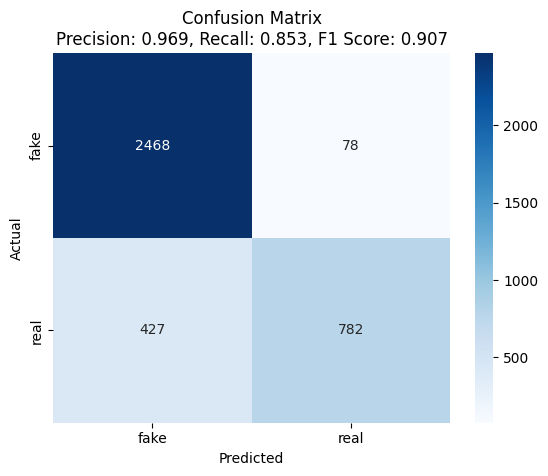

In [149]:
# Feature extraction using TF-IDF
tfidfVectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = tfidfVectorizer.fit_transform(train_df['finalTweetStemLemmatize'])
X_test_tfidf = tfidfVectorizer.transform(test_df['finalTweetStemLemmatize'])

# # Apply PCA for dimensionality reduction
# n_components = 1000  # Number of components to reduce to
# pca = PCA(n_components=n_components)
# X_train_reduced = pca.fit_transform(X_train_tfidf.toarray())  # Fit PCA on training data
# X_test_reduced = pca.transform(X_test_tfidf.toarray())  # Transform test data using the same PCA

# Create a Random Forest classifier
rfc_tfidf = RandomForestClassifier(random_state=45)

# Train the Random Forest classifier
rfc_tfidf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
rfcPrediction_tfid = rfc_tfidf.predict(X_test_tfidf)

getMetrics(y_test, rfcPrediction_tfid)

Confusion Matrix:
[[2057  489]
 [ 342  867]]
TP: 2057 FP: 489 TN: 867 FN: 342
Precision: 0.808
Recall: 0.857
F1 Score: 0.832


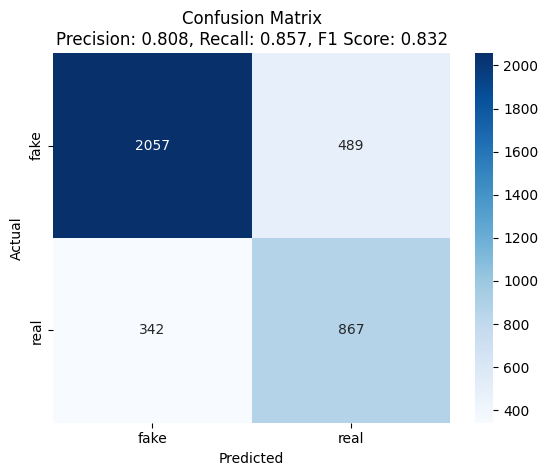

In [150]:
total_samples = len(y_train)
class_weights = {
    'fake': total_samples / (2 * 9345),  # Weight for 'fake' class
    'real': total_samples / (2 * 4914)  # Weight for 'real' class
}

countfVectorizer = CountVectorizer()
X_train_count = countfVectorizer.fit_transform(train_df['finalTweetLemmatize'])
X_test_count = countfVectorizer.transform(test_df['finalTweetLemmatize'])

# Create a Support Vector Machine
# svm_tfifd = SVC(kernel='linear', C=0.58)
svm_tfifd = SVC(kernel='linear', C=0.17, class_weight=class_weights)

# Train the Support Vector Machine
svm_tfifd.fit(X_train_count, y_train)
 
# Make predictions on the test set
svmPrediction_tfifd = svm_tfifd.predict(X_test_count)

getMetrics(y_test, svmPrediction_tfifd)